In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from kneed import KneeLocator

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/saujanya01/kprototype_clustering/master/customer_data.csv")

In [3]:
customer = df[:100]
customer.head(5)

,age,job,marital,education,default,housing,loan,comm_type,month,day_of_week,last_contact_duration,campaign_contact_count,poutcome,cons.price.idx,cons.conf.idx,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,nonexistent,93.994,-36.4,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,nonexistent,93.994,-36.4,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,nonexistent,93.994,-36.4,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,nonexistent,93.994,-36.4,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,nonexistent,93.994,-36.4,5191.0


## Related to customer
1 - age (numeric)

2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

5 - default: has credit in default? (categorical: "no","yes","unknown")

6 - housing: has housing loan? (categorical: "no","yes","unknown")

7 - loan: has personal loan? (categorical: "no","yes","unknown")

## related with the last contact of the current campaign:

8 - comm_type: contact communication type (categorical: "cellular","telephone") 

9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

11 - last_contact_duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

## other attributes(contact behaviour):

12 - campaign_contact_count: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

## social and economic context attributes

14 - cons.price.idx: consumer price index - monthly indicator (numeric)     

15 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     

16 - nr.employed: number of employees - quarterly indicator (numeric)(drop)

In [4]:
customer.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'comm_type', 'month', 'day_of_week', 'last_contact_duration',
       'campaign_contact_count', 'poutcome', 'cons.price.idx', 'cons.conf.idx',
       'nr.employed'],
      dtype='object')

## Details of each column

In [5]:
for i in customer.columns:
    print(i)
    print(customer[i].value_counts())
    print("\n--------------------------------------\n")

age
55    9
41    7
42    6
57    6
54    5
37    5
44    5
35    5
56    4
39    4
45    4
33    3
50    3
49    3
38    3
59    3
25    3
34    2
40    2
60    2
46    2
47    2
51    2
53    2
48    1
52    1
32    1
31    1
30    1
29    1
58    1
24    1
Name: age, dtype: int64

--------------------------------------

job
admin.           26
blue-collar      24
technician       15
services         10
management        9
unknown           4
entrepreneur      3
housemaid         3
unemployed        3
retired           2
self-employed     1
Name: job, dtype: int64

--------------------------------------

marital
married     77
single      16
divorced     6
unknown      1
Name: marital, dtype: int64

--------------------------------------

education
university.degree      23
high.school            20
basic.9y               14
basic.4y               13
unknown                11
basic.6y               10
professional.course     9
Name: education, dtype: int64

--------------------------

## Columns(numeric value) with cateorical values are stored in list 'ind'. 'c_data' has names of column with categorical data

In [6]:
ind = []
l = customer.dtypes
for i in range(len(l)):
    if (str(l[i])=='object'):
        ind.append(i)
c_data = [customer.columns[i] for i in ind]
c_data

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'comm_type',
 'month',
 'day_of_week',
 'poutcome']

## dictionary 'd' stores column name as key and index as value. In K-prototype all columns should have numeric indices

In [7]:
d={}
k=0
for i in customer.columns:
    d[i]=k
    k=k+1

## Renaming the columns

In [8]:
customer.rename(columns=d,inplace=True)

/home/saujanya/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
customer.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,nonexistent,93.994,-36.4,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,nonexistent,93.994,-36.4,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,nonexistent,93.994,-36.4,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,nonexistent,93.994,-36.4,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,nonexistent,93.994,-36.4,5191.0


In [10]:
c_list=[]
cluster_dict={}
for i in range(1,11):
    kproto = KPrototypes(n_clusters=i, init='Cao', verbose=2)
    clusters = kproto.fit_predict(customer, categorical=ind)
    cluster_dict[i]=clusters
    c_list.append(kproto.cost_)
    print("------------------------------------------------------")

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 7918580.066852473
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 7918580.066852473
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 7918580.066852473
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 7918580.066852473
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 7918580.066852473
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 7918580.066852473
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 7918580.066852473
Init: initial

Run: 2, iteration: 1/100, moves: 7, ncost: 1310012.9842430535
Run: 2, iteration: 2/100, moves: 3, ncost: 1090999.3345341603
Run: 2, iteration: 3/100, moves: 4, ncost: 1080890.2685488807
Run: 2, iteration: 4/100, moves: 1, ncost: 1080326.5148681237
Run: 2, iteration: 5/100, moves: 1, ncost: 1079659.6092205397
Run: 2, iteration: 6/100, moves: 3, ncost: 1077403.0452479576
Run: 2, iteration: 7/100, moves: 0, ncost: 1077403.0452479576
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 12, ncost: 900784.7933989726
Run: 3, iteration: 2/100, moves: 8, ncost: 868365.6053748092
Run: 3, iteration: 3/100, moves: 5, ncost: 859457.7079709772
Run: 3, iteration: 4/100, moves: 0, ncost: 859457.7079709772
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 22, ncost: 1278324.5192808355
Run: 4, iteration: 2/100, moves: 14, ncost: 914516.8304579849
Run: 4, iteration: 3/100, moves: 4, 

Run: 3, iteration: 1/100, moves: 11, ncost: 633903.7677060731
Run: 3, iteration: 2/100, moves: 2, ncost: 506738.1655349338
Run: 3, iteration: 3/100, moves: 2, ncost: 460059.12570495484
Run: 3, iteration: 4/100, moves: 0, ncost: 460059.12570495484
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 20, ncost: 642319.7374157675
Run: 4, iteration: 2/100, moves: 8, ncost: 590298.6224506097
Run: 4, iteration: 3/100, moves: 9, ncost: 571000.7989438778
Run: 4, iteration: 4/100, moves: 1, ncost: 569741.3002730256
Run: 4, iteration: 5/100, moves: 0, ncost: 569741.3002730256
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 22, ncost: 907801.079743964
Run: 5, iteration: 2/100, moves: 14, ncost: 640409.6509585173
Run: 5, iteration: 3/100, moves: 5, ncost: 635229.8376007173
Run: 5, iteration: 4/100, moves: 5, ncost: 631

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 22, ncost: 443615.2583946946
Run: 2, iteration: 2/100, moves: 8, ncost: 422698.424466046
Run: 2, iteration: 3/100, moves: 14, ncost: 398024.1746460685
Run: 2, iteration: 4/100, moves: 9, ncost: 383066.73860082147
Run: 2, iteration: 5/100, moves: 5, ncost: 374871.2301668147
Run: 2, iteration: 6/100, moves: 5, ncost: 366387.0460453638
Run: 2, iteration: 7/100, moves: 3, ncost: 364160.14201843366
Run: 2, iteration: 8/100, moves: 6, ncost: 357603.9287824307
Run: 2, iteration: 9/100, moves: 5, ncost: 355628.82291411096
Run: 2, iteration: 10/100, moves: 1, ncost: 355509.53583096346
Run: 2, iteration: 11/100, moves: 0, ncost: 355509.53583096346
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initial

Run: 6, iteration: 8/100, moves: 0, ncost: 341155.83409533475
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 17, ncost: 380662.93947910203
Run: 7, iteration: 2/100, moves: 10, ncost: 369931.5764790792
Run: 7, iteration: 3/100, moves: 13, ncost: 352787.80376801046
Run: 7, iteration: 4/100, moves: 6, ncost: 350488.9455417348
Run: 7, iteration: 5/100, moves: 1, ncost: 350369.6584585873
Run: 7, iteration: 6/100, moves: 0, ncost: 350369.6584585873
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 23, ncost: 370928.5546307816
Run: 8, iteration: 2/100, moves: 9, ncost: 348521.94700582605
Run: 8, iteration: 3/100, moves: 3, ncost: 347709.47106956184
Run: 8, iteration: 4/100, moves: 0, ncost: 347709.47106956184
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializi

## Elbow Plot

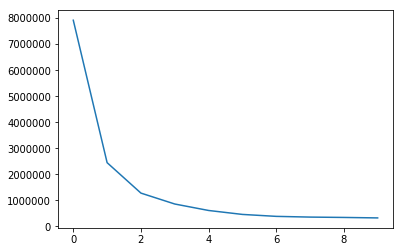

In [29]:
sns.lineplot(y=c_list,x=range(0,len(c_list)))

## Locating Elbow for adequate number of cluster

In [30]:
y=c_list
x = range(1, len(y)+1)
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print("Number of clusters : ",kn.knee)

Number of clusters :  3


## Every cluster is stored in dictionary cd(starting from index 0). cd[n]=(n-1)th cluster

In [25]:
final_cluster = cluster_dict[kn.knee]
cd={}
for i in range(kn.knee):
    cd[i]=[]
    
for i in range(0,len(final_cluster)):
    cd[final_cluster[i]].append(list(customer.iloc[i]))

column = list(df.columns)
for i in range(len(cd)):
    cd[i]=pd.DataFrame(cd[i],columns=column)

In [26]:
cd[0]

,age,job,marital,education,default,housing,loan,comm_type,month,day_of_week,last_contact_duration,campaign_contact_count,poutcome,cons.price.idx,cons.conf.idx,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,nonexistent,93.994,-36.4,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,nonexistent,93.994,-36.4,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,nonexistent,93.994,-36.4,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,nonexistent,93.994,-36.4,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,nonexistent,93.994,-36.4,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,60,admin.,married,unknown,unknown,no,yes,telephone,may,mon,213,2,nonexistent,93.994,-36.4,5191.0
66,45,services,married,professional.course,no,yes,no,telephone,may,mon,221,1,nonexistent,93.994,-36.4,5191.0
67,53,admin.,divorced,university.degree,unknown,no,no,telephone,may,mon,287,1,nonexistent,93.994,-36.4,5191.0
68,37,technician,single,professional.course,no,no,no,telephone,may,mon,197,1,nonexistent,93.994,-36.4,5191.0


In [27]:
cd[1]

,age,job,marital,education,default,housing,loan,comm_type,month,day_of_week,last_contact_duration,campaign_contact_count,poutcome,cons.price.idx,cons.conf.idx,nr.employed
0,52,technician,married,basic.9y,no,yes,no,telephone,may,mon,1666,1,nonexistent,93.994,-36.4,5191.0
1,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,1575,1,nonexistent,93.994,-36.4,5191.0
2,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,1042,1,nonexistent,93.994,-36.4,5191.0
3,49,technician,married,basic.9y,no,no,no,telephone,may,mon,1467,1,nonexistent,93.994,-36.4,5191.0


In [28]:
cd[2]

,age,job,marital,education,default,housing,loan,comm_type,month,day_of_week,last_contact_duration,campaign_contact_count,poutcome,cons.price.idx,cons.conf.idx,nr.employed
0,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,nonexistent,93.994,-36.4,5191.0
1,35,blue-collar,married,basic.6y,no,yes,no,telephone,may,mon,312,1,nonexistent,93.994,-36.4,5191.0
2,46,blue-collar,married,basic.6y,unknown,yes,yes,telephone,may,mon,440,1,nonexistent,93.994,-36.4,5191.0
3,50,blue-collar,married,basic.9y,no,yes,yes,telephone,may,mon,353,1,nonexistent,93.994,-36.4,5191.0
4,55,retired,single,high.school,no,yes,no,telephone,may,mon,342,1,nonexistent,93.994,-36.4,5191.0
5,55,unknown,married,university.degree,unknown,unknown,unknown,telephone,may,mon,362,1,nonexistent,93.994,-36.4,5191.0
6,46,admin.,married,unknown,no,no,no,telephone,may,mon,348,1,nonexistent,93.994,-36.4,5191.0
7,59,technician,married,unknown,no,yes,no,telephone,may,mon,386,1,nonexistent,93.994,-36.4,5191.0
8,55,unknown,married,basic.4y,unknown,yes,no,telephone,may,mon,336,1,nonexistent,93.994,-36.4,5191.0
9,34,services,married,high.school,no,no,no,telephone,may,mon,365,1,nonexistent,93.994,-36.4,5191.0
